In [52]:
import pandas as pd

In [53]:
processed = 'processed'
features  = 'features'

In [54]:
df_train = pd.read_csv(f'{processed}/train.csv')
df_test = pd.read_csv(f'{processed}/test.csv')

In [55]:
for feature_pack in ['age_human', 'age_quantiles', 'pclass_dummy']:
    df_train = df_train.merge(pd.read_csv(f'{features}/{feature_pack}_train.csv'))
    df_test = df_test.merge(pd.read_csv(f'{features}/{feature_pack}_test.csv'))

In [56]:
df_test.columns

Index(['PassengerId', 'Survived', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'src', 'Sex_female', 'Sex_male',
       'Age_na', 'Age_is(0..2]', 'Age_is(2..6]', 'Age_is(6..14]',
       'Age_is(14..16]', 'Age_is(16..18]', 'Age_is(18..25]', 'Age_is(25..35]',
       'Age_is(35..40]', 'Age_is(40..45]', 'Age_is(45..60]', 'Age_is(60..80]',
       'Age_q_is(0.169..14.0]', 'Age_q_is(14.0..19.0]', 'Age_q_is(19.0..22.0]',
       'Age_q_is(22.0..25.0]', 'Age_q_is(25.0..28.0]', 'Age_q_is(28.0..31.0]',
       'Age_q_is(31.0..36.0]', 'Age_q_is(36.0..42.0]', 'Age_q_is(42.0..50.0]',
       'Age_q_is(50.0..80.0]', 'Pclass_is_1', 'Pclass_is_2', 'Pclass_is_3'],
      dtype='object')

In [64]:
field_name = 'Survived'

feature_names = []
feature_names += [name for name in df_test.columns if 'Sex_' in name]
feature_names += [name for name in df_test.columns if 'Age_is_' in name]
feature_names += [name for name in df_test.columns if 'Age_q_' in name]
feature_names += [name for name in df_test.columns if 'Pclass_is_' in name]

feature_names

['Sex_female',
 'Sex_male',
 'Age_q_is(0.169..14.0]',
 'Age_q_is(14.0..19.0]',
 'Age_q_is(19.0..22.0]',
 'Age_q_is(22.0..25.0]',
 'Age_q_is(25.0..28.0]',
 'Age_q_is(28.0..31.0]',
 'Age_q_is(31.0..36.0]',
 'Age_q_is(36.0..42.0]',
 'Age_q_is(42.0..50.0]',
 'Age_q_is(50.0..80.0]',
 'Pclass_is_1',
 'Pclass_is_2',
 'Pclass_is_3']

In [65]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold = KFold(random_state=42, n_splits=3)
cl = GradientBoostingClassifier()
cross_val_score(cl, df_train[feature_names], df_train[field_name], cv=kfold)

array([0.81144781, 0.81481481, 0.82491582])

In [69]:
%matplotlib inline
import seaborn as sns

## Feature importance of a healthy model

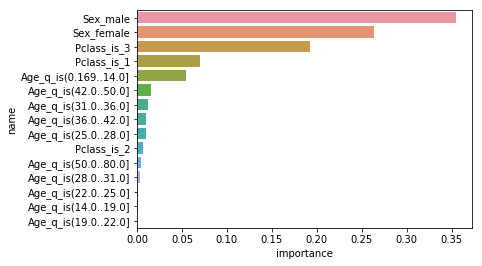

In [70]:
cl.fit(df_train[feature_names], df_train[field_name])
df_features = pd.DataFrame({'name': feature_names, 'importance': cl.feature_importances_})
df_features.sort_values('importance', ascending=False, inplace=True)
sns.barplot(x="importance", y="name", data=df_features)

## Feature importance of a model trained against unif noise labels

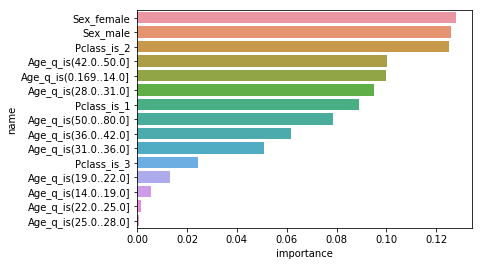

In [78]:
import numpy as np
from numpy import random
zero_one_noise = random.randint(low=0, high=2, size=df_train[field_name].shape)

cl.fit(df_train[feature_names], zero_one_noise)
df_features = pd.DataFrame({'name': feature_names, 'importance': cl.feature_importances_})
df_features.sort_values('importance', ascending=False, inplace=True)
sns.barplot(x="importance", y="name", data=df_features)

## Feature importance for a unif 0/1 indicator noise


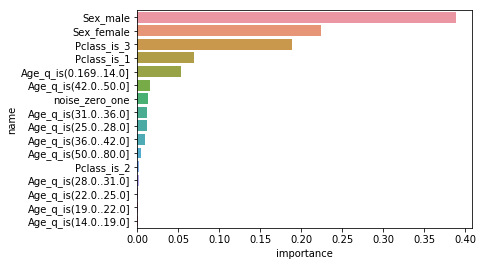

In [88]:
fns = feature_names + ['noise_zero_one']
df_train['noise_zero_one'] = zero_one_noise
cl.fit(df_train[fns], df_train[field_name])
df_features = pd.DataFrame({'name': fns, 'importance': cl.feature_importances_})
df_features.sort_values('importance', ascending=False, inplace=True)
sns.barplot(x="importance", y="name", data=df_features)

## Feature importance for a float unif noise

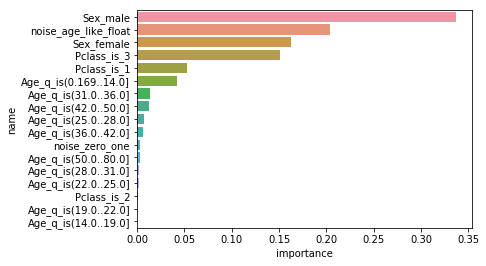

In [90]:
fns = feature_names + ['noise_zero_one', 'noise_age_like_float']
df_train['noise_age_like_float'] = random.uniform(low=df_train['Fare'].min(), high=df_train['Fare'].max(), size=df_train[field_name].shape)
cl.fit(df_train[fns], df_train[field_name])
df_features = pd.DataFrame({'name': fns, 'importance': cl.feature_importances_})
df_features.sort_values('importance', ascending=False, inplace=True)
sns.barplot(x="importance", y="name", data=df_features)

### -- // -- rescaled

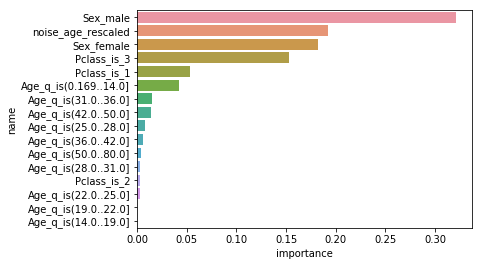

In [108]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_train['noise_age_rescaled'] = scaler.fit_transform(df_train[['noise_age_like_float']])[:,0]
fns = feature_names + ['noise_age_rescaled']

cl.fit(df_train[fns], df_train[field_name])
df_features = pd.DataFrame({'name': fns, 'importance': cl.feature_importances_})
df_features.sort_values('importance', ascending=False, inplace=True)
sns.barplot(x="importance", y="name", data=df_features)